In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


Import necessary libraries

Data Import and Cleaning

In [25]:
# Load the dataset
df = pd.read_excel(r"C:\Users\DELL\Downloads\online+retail\Online Retail.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [26]:
#delete null value
df = df.dropna(subset=['CustomerID'])

#change the necessary data type
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

#drop duplicates
df = df.drop_duplicates(subset=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID'], keep='first')

#skip unrealistic values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


In [27]:
#Compute total price
TotalPrice = df['Quantity'] * df['UnitPrice']
df['TotalPrice'] = TotalPrice

Create a def function to compute rftm (Recency, Frequency, Tenure and Monetary)

In [28]:

def compute_rftm(data):
    # Filter out cancellation invoices
    purchases = data[~data['InvoiceNo'].astype(str).str.startswith('C', na=False)]
    
    # Group by CustomerID and compute metrics
    rftm = purchases.groupby('CustomerID').agg(
        FirstPurchaseDate=('InvoiceDate', 'min'), 
        LastPurchaseDate=('InvoiceDate', 'max'), 
        Frequency=('InvoiceNo', 'nunique'),
        Monetary=('TotalPrice', 'sum')
    ).reset_index()
    
    # Calculate Recency and Tenure
    reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
    rftm['Recency'] = (reference_date - rftm['LastPurchaseDate']).dt.days
    rftm['Tenure'] = (rftm['LastPurchaseDate'] - rftm['FirstPurchaseDate']).dt.days
    
    # Remove customers with no purchases 
    rftm = rftm[rftm['Frequency'] > 0].drop(
        columns=['FirstPurchaseDate', 'LastPurchaseDate']
    )
    
    return rftm

rftm_df = compute_rftm(df)

# print the first few rows of the RFTM DataFrame
print(rftm_df.head())

# Calculate and print churn rate as a bonus
churn_rate = (rftm_df['Recency'] > 90).mean()
print(f"\nChurn Rate (90-day inactivity): {churn_rate:.1%}")

   CustomerID  Frequency  Monetary  Recency  Tenure
0     12346.0          1  77183.60      326       0
1     12347.0          7   4310.00        2     365
2     12348.0          4   1797.24       75     282
3     12349.0          1   1757.55       19       0
4     12350.0          1    334.40      310       0

Churn Rate (90-day inactivity): 33.4%


Scale the features for clustering. I chose Frequency, Monetary and Tenure as features since I believe that these can best divide the different types of customer

In [29]:
# Select features for clustering
features = rftm_df[[ 'Frequency', 'Monetary', 'Tenure']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Compute wcss and plot elbow curve

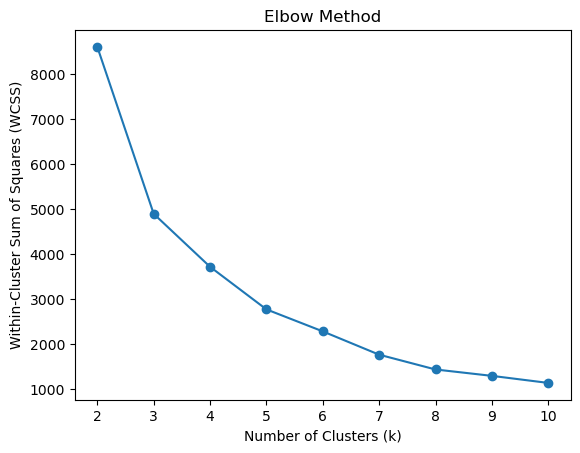

In [30]:
# Compute WCSS for k = 2 to 10
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

According to elbow curve, K should be 3 . Then perform K means clustering.

   CustomerID  Frequency  Monetary  Recency  Tenure  Cluster
0     12346.0          1  77183.60      326       0        1
1     12347.0          7   4310.00        2     365        0
2     12348.0          4   1797.24       75     282        0
3     12349.0          1   1757.55       19       0        1
4     12350.0          1    334.40      310       0        1
   Frequency      Monetary      Tenure
0   7.043875   2839.225545  272.887749
1   1.737583    654.239356   30.497458
2  66.423077  85826.078077  345.615385


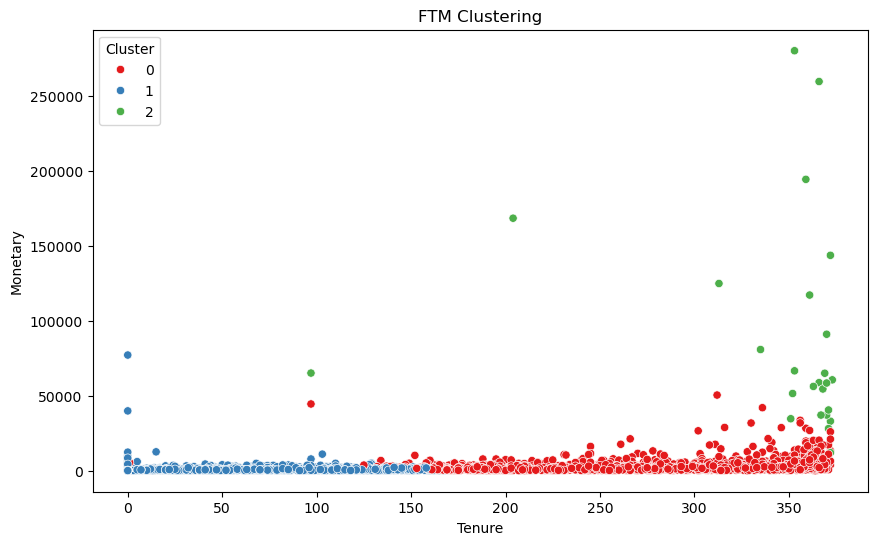

In [31]:
# Perform K-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
rftm_df['Cluster'] = kmeans.fit_predict(features_scaled)

print(rftm_df.head())

# inverse transform the cluster centers to original scale

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Frequency', 'Monetary', 'Tenure'])
print(cluster_centers_df)

# Visualize the clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rftm_df, x='Tenure', y='Monetary', hue='Cluster', palette='Set1')
plt.title('FTM Clustering')
plt.xlabel('Tenure')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()


Evaluate the clustering results

In [32]:
# Calculate silhouette score
silhouette_avg = silhouette_score(features_scaled, rftm_df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6317581405394801


0.63 suggests that the clusters are well separated.

In [33]:
#calculate mean values for each cluster
cluster_means = rftm_df.groupby('Cluster')[['Frequency', 'Monetary', 'Tenure']].mean().reset_index()
print(cluster_means)

   Cluster  Frequency      Monetary      Tenure
0        0   7.043875   2839.225545  272.887749
1        1   1.737583    654.239356   30.497458
2        2  66.423077  85826.078077  345.615385


Predict using Random Forest Classifier

I ranked the customer groups based on how valuable they are based on mean values. For features, recency is used to predict in stead of tenure since it could be more convenient to find in real life and prevent data leakage and unrealtistic accuracy score.

In [36]:
rftm_df['CLV'] = 0
rftm_df.loc[rftm_df['Cluster'] == 0, 'CLV'] = 1
rftm_df.loc[rftm_df['Cluster'] == 1, 'CLV'] = 0
rftm_df.loc[rftm_df['Cluster'] == 2, 'CLV'] = 2
rftm_df['CLV'] = rftm_df['CLV'].astype(int)
# Prepare features and target
X = rftm_df[['Recency', 'Frequency', 'Monetary']]
y = rftm_df['CLV']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)


Accuracy: 0.8294930875576036
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       511
           1       0.79      0.79      0.79       351
           2       0.86      1.00      0.92         6

    accuracy                           0.83       868
   macro avg       0.83      0.88      0.86       868
weighted avg       0.83      0.83      0.83       868



,Feature,Importance
1,Frequency,0.381190
2,Monetary,0.368748
0,Recency,0.250062


The Accuracy score is 83% which is generally decent and the features are reasonably important

In [37]:
#save the model

import joblib
joblib.dump(clf, 'rftm_model.pkl')

['rftm_model.pkl']